In [1]:
import numpy as np
import pandas as pd
import os

import re
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import plot

# ADDITIONAL DEF

In [2]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print(f'{col} column missing values: {df[col].isnull().sum()} an null values {(df[col]==0).sum()}')
    print('\n')
    
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('russian')]

def words_unique(label,numwords,raw_words, train):
    '''
    Input:
        label - label of the text;
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times 
        it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.label != label]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.label == label]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

# EDA

In [3]:
dfx_train = pd.read_json('/kaggle/input/kontur2023/nlp_test_task_2023/nlp_test_task_2023/dataset/train.json')
splitted_df = pd.json_normalize(dfx_train.extracted_part)
splitted_df['extracted_part'] = splitted_df['text']
for i in ['extracted_part', 'answer_start', 'answer_end']:
    dfx_train[i] = splitted_df[i].str[0]
dfx_train

,id,text,label,extracted_part,answer_start,answer_end
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 6593.2...,1279,1343
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,Поставщик должен предоставить обеспечение испо...,1222,1318
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%,1297,1343
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%,1304,1350
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%,1302,1348
...,...,...,...,...,...,...
1794,938335285,"«УТВЕРЖДАЮ» Директор МУП ""ПКП и ОРТ"" _________...",обеспечение гарантийных обязательств,Заказчиком установлено требование обеспечения ...,1213,1402
1795,214609521,ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...,обеспечение гарантийных обязательств,,0,0
1796,94811748,ДОГОВОР ПОДРЯДА № _____ «___»___________20____...,обеспечение гарантийных обязательств,,0,0
1797,903507299,ДОКУМЕНТАЦИЯ О ЗАКУПКЕ ЗАПРОС ПРЕДЛОЖЕНИЙ В ЭЛ...,обеспечение гарантийных обязательств,,0,0


id column missing values: 0 an null values 0
text column missing values: 0 an null values 0
label column missing values: 0 an null values 0
extracted_part column missing values: 0 an null values 0
answer_start column missing values: 0 an null values 307
answer_end column missing values: 0 an null values 307




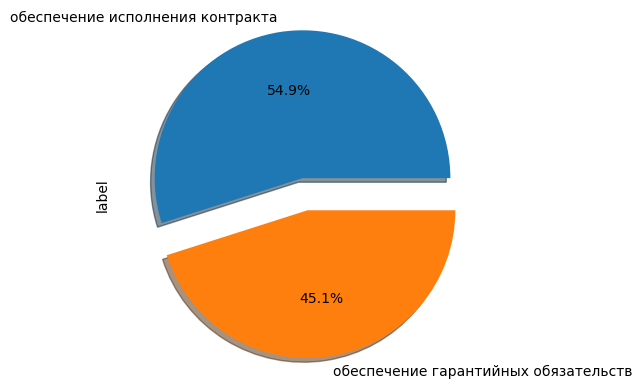

In [4]:
# let's see the distribution of data by labels.
dfx_train['label'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,explode=[0.11 , 0.11])
display_missing(dfx_train)

* The diagram shows that the classes are distributed approximately equally.
* But there are a large number of null values in the training set. This should be taken into account when splitting into training and validation sets.

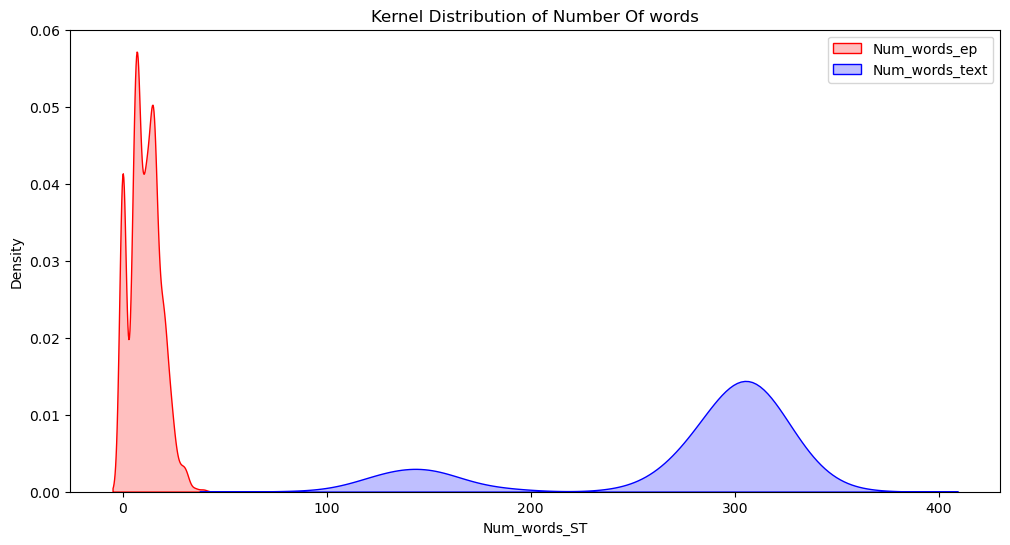

In [5]:
dfx_train['Num_words_ST'] = dfx_train['extracted_part'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
dfx_train['Num_word_text'] = dfx_train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text

# Create a plot with num words distribution
plt.figure(figsize=(12,6))
p1=sns.kdeplot(dfx_train['Num_words_ST'], fill=True, color="r", label='Num_words_ep').set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(dfx_train['Num_word_text'], fill=True, color="b", label='Num_words_text')
plt.legend()
plt.show()

* The desired fragment is a small part of the entire text.
* And the texts themselves are divided into two clusters according to the number of words.

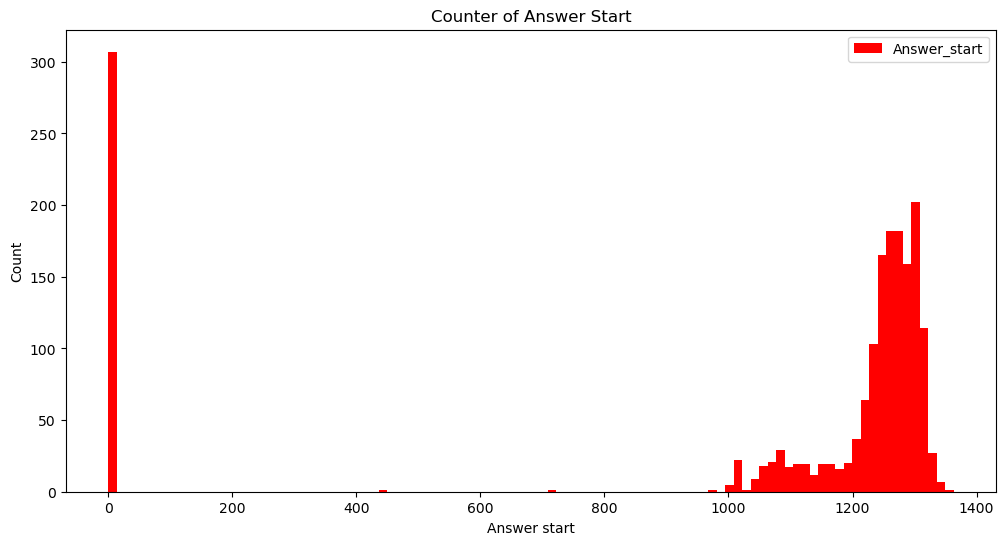

In [13]:
# Create a plot with answer start distribution
plt.figure(figsize=(12,6))
p1=plt.hist(dfx_train['answer_start'], bins=100, color="r", label='Answer_start')
plt.gca().set(title='Counter of Answer Start',xlabel='Answer start', ylabel='Count');
plt.legend()
plt.show()

* The distribution of the beginning of the answer has a non-normal distribution. There are a large number of texts with no extracted part.

In [76]:
# Common words in extracted part column.
dfx_train['text'] = dfx_train['text'].apply(lambda x:clean_text(x))
dfx_train['extracted_part'] = dfx_train['extracted_part'].apply(lambda x:clean_text(x))
dfx_train['temp_list'] = dfx_train['extracted_part'].apply(lambda x:str(x).split())
dfx_train['temp_list'] = dfx_train['temp_list'].apply(lambda x:remove_stopword(x))

top = Counter([item for sublist in dfx_train['temp_list'] for item in sublist])
temp1 = pd.DataFrame(top.most_common(20))
temp1 = temp1.iloc[1:,:]
temp1.columns = ['Common_words','count']
temp1.style.background_gradient(cmap='Purples')

,Common_words,count
1,исполнения,1046
2,обеспечения,1003
3,размер,960
4,цены,937
5,договора,877
6,начальной,681
7,максимальной,679
8,обязательств,542
9,гарантийных,526
10,обеспечение,520


In [37]:
# Common words in whole text.
dfx_train['temp_list1'] = dfx_train['text'].apply(lambda x:str(x).split()) #List of words in every row for text.
dfx_train['temp_list1'] = dfx_train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords.
top = Counter([item for sublist in dfx_train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,контракта,7725
2,обеспечения,6758
3,договора,5921
4,№,4940
5,закупки,4839
6,обеспечение,4583
7,обязательств,4146
8,соответствии,3158
9,гарантии,3114
10,гарантийных,2812


In [38]:
label_1 = dfx_train[dfx_train['label']=='обеспечение исполнения контракта']
label_2 = dfx_train[dfx_train['label']=='обеспечение гарантийных обязательств']

In [39]:
#MosT common words for label: обеспечение исполнения контракта
top = Counter([item for sublist in label_1['temp_list'] for item in sublist])
temp_1 = pd.DataFrame(top.most_common(20))
temp_1.columns = ['Common_words','count']
temp_1.style.background_gradient(cmap='Greens')

,Common_words,count
0,исполнения,961
1,контракта,867
2,договора,773
3,цены,659
4,размер,589
5,обеспечения,589
6,начальной,449
7,максимальной,447
8,обеспечение,397
9,размере,334


In [40]:
#MosT common words for label: обеспечение гарантийных обязательств
top = Counter([item for sublist in label_2['temp_list'] for item in sublist])
temp_2 = pd.DataFrame(top.most_common(20))
temp_2 = temp_2.iloc[1:,:]
temp_2.columns = ['Common_words','count']
temp_2.style.background_gradient(cmap='Reds')

,Common_words,count
1,гарантийных,523
2,обеспечения,414
3,размер,371
4,цены,278
5,начальной,232
6,максимальной,232
7,составляет,215
8,контракта,188
9,российский,176
10,рубль,176


* The common words for these two texts are different, which means they can be somehow separated.

In [48]:
raw_text = [word for word_list in dfx_train['temp_list1'] for word in word_list]

Unique_Positive= words_unique('обеспечение исполнения контракта', 10, raw_text, dfx_train)
print("The top 10 unique words in 'обеспечение исполнения контракта':")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 10 unique words in 'обеспечение исполнения контракта':


,words,count
0,аномально,97
1,бюджетным,90
2,унитарными,88
3,предприятиями,88
4,особенностей,88
5,выдача,87
6,контрактам,87
7,отказом,80
8,эквивалентном,78
9,первоначально,73


In [49]:
Unique_Negative= words_unique('обеспечение гарантийных обязательств', 10, raw_text, dfx_train)
print("The top 10 unique words in 'обеспечение гарантийных обязательств:'")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in 'обеспечение гарантийных обязательств:'


,words,count
0,коммерческая,38
1,части»,38
2,рао,33
3,«интер,32
4,электрогенерация»,28
5,атомной,20
6,акте,19
7,волга»,18
8,подтверждающими,16
9,городе,16


* The same is true for unique words.

## TEST DATA

In [77]:
dfx_test = pd.read_json('/kaggle/input/kontur2023/nlp_test_task_2023/nlp_test_task_2023/dataset/test.json')
dfx_test.loc[:, 'extracted_part'] = dfx_test.text.values
dfx_test.loc[:, 'answer_start'] = 0
dfx_test.loc[:, 'answer_end'] = dfx_test.text.str.len() 

id column missing values: 0 an null values 0
text column missing values: 0 an null values 0
label column missing values: 0 an null values 0
extracted_part column missing values: 0 an null values 0
answer_start column missing values: 0 an null values 318
answer_end column missing values: 0 an null values 0




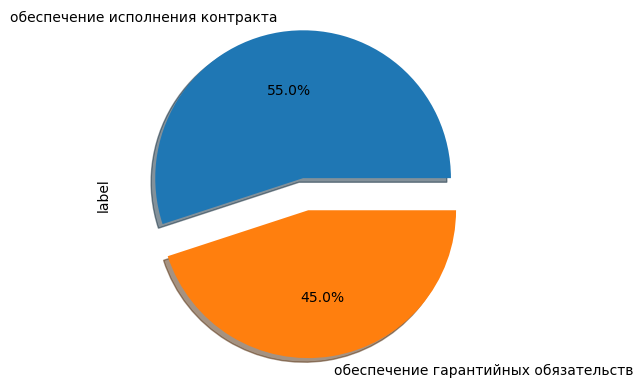

In [79]:
# let's see the distribution of data by labels.
dfx_test['label'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,explode=[0.11 , 0.11])
display_missing(dfx_test)